Data Scraping 

Scraping the data is done by running the code below. The scraper below allows you to gather NFL combine and draft data for the the time period from 2000 to 2020 and historical college football stats of the players from this time interval. The code of scraper was adapted from a post from Sean J. Taylor.

(Source: https://github.com/seanjtaylor/learning-the-draft/blob/master/scrape_pfr.R retrieved in September 2020.)

Scrapper function creates three dataframes which summarize crucial information about the career of the college player; combine.table (NFL scouting combine), draft.table (results of NFL draft and pick trades) and college.stats (historical college stats of college players). Draft and combine data are gathered per year from pro-football-reference.com and the historical college stats of associated football players were scraped from sports-reference.com. 

We made following changes to adapt the scraper to our purpose:

The cited github repository used Rcurl package to compose the HTTP requests. However, the webpages for the college stats of recent years required the TLS version 1.2, which wasn´t supported by Rcurl package and the scraper function failed to open the contents of these urls. Therefore, we needed to rewrite the code with httr package and functions.   

The scraper was rewritten to gather combine, draft and collage stats data from last twenty years. 

We calculated the average of relevant college stats instead of taking the sum of all historical value. 


In [ ]:
# install.packages("feather")
#install.packages("httr")
library(rvest)
library(readr)
library(dplyr)
library(httr)
library(tidyr)
library(stringr)
library(feather)

In [3]:
# create folders to strore data and http caches 
dir.create("cache")

dir.create("data")

Warning message in dir.create("cache"):
"'cache' existiert bereits"
Warning message in dir.create("data"):
"'data' existiert bereits"


In [4]:
# html cache function to read the url content 

read_html_cache <- function(url, cache.dir = 'cache') {
  fn <- tail(strsplit(url, '/')[[1]], 1)
  fn.path <- paste(cache.dir, fn, sep = '/')
  if (!file.exists(fn.path)) {
    text <- content(GET(url), as="text")
    write(text, fn.path)
  }
  read_html(fn.path)
}

# headers of draft and combine dataframes 
draft.header <- c('round', 'pick', 'team', 'player', 'pos', 'age', 'to', 'ap1', 'pb', 'st', 'carav', 'drav', 'games', 
                  'pass.cmp', 'pass.att', 'pass.yds', 'pass.tds', 'pass.ints', 'rush.att', 'rush.yds', 'rush.tds', 'receptions', 'rec.yds', 'rec.tds', 'tackles', 'ints', 'sacks', 'college', 'stats')
combine.header <- c('player', 'pos', 'college', 'stats', 'height', 'weight', 'forty', 'vertical', 'bench', 'broad',
                    'threecone', 'shuttle', 'drafted')

url.extract <- function(tds) {
  results <- c()
  for(td in tds) {
    children <- html_children(td)
    if (length(children) == 0) {
      results <- c(results, NA)
    } else{
      results <- c(results, (html_attr(html_children(td), 'href')))
    }
  }
  results
}

# headers of college stats
headers <- list()
headers[['defense']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'solo.tackes', 'ast.tackles', 'tackles', 'loss.tackles', 'sacks', 'int', 'int.yards', 'int.yards.avg', 'int.td', 'pd', 'fum.rec', 'fum.yds', 'fum.tds', 'fum.forced')
headers[['scoring']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'td.rush', 'td.rec', 'td.int', 'td.fr', 'td.pr', 'td.kr', 'td.oth', 'td.tot', 'kick.xpm', 'kick.fgm', 'twopm', 'safety', 'total.pts')
headers[['punt_ret']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'punt.returns', 'punt.return.yards', 'punt.return.avg', 'punt.return.td', 'kick.returns', 'kick.return.yards', 'kick.return.avg', 'kick.return.td')
headers[['receiving']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'receptions', 'rec.yards', 'rec.avg', 'rec.td', 'rush.att', 'rush.yds', 'rush.avg', 'rush.td', 'scrim.plays', 'scrim.yds', 'scrim.avg', 'scrim.tds')
headers[['rushing']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'receptions', 'rec.yards', 'rec.avg', 'rec.td', 'rush.att', 'rush.yds', 'rush.avg', 'rush.td', 'scrim.plays', 'scrim.yds', 'scrim.avg', 'scrim.tds')
headers[['passing']] <- c('year', 'school', 'conf', 'class', 'pos', 'games', 'completions', 'attempts', 'comp.pct', 'pass.yards', 'yards.per.attempt', 'adj.yards.per.attempt', 'pass.tds', 'pass.ints', 'int.rate')

parse_pfr_tables <- function(tables) {
  results = list()
  for (tbl in tables) {
    id <- html_attr(tbl, 'id')
    if (id %in% names(headers)) {
      
      df <- html_table(tbl) %>%
        head(-1) %>% tail(-1)
      
      if(ncol(df) == length(headers[[id]])) {
        colnames(df) <- headers[[id]]
      } else {
        next;
      }
      
      melted <- df %>%
        select(-year, -school, -conf, -class, -pos) %>%
        mutate(seasons = 1) %>%
        gather(stat, value) %>%
        mutate(stat = as.character(stat)) %>%
        filter(value != '') %>%
        mutate(value = as.numeric(value),
               section = id)
      
      
      results[[id]] <- melted
    }
  }
  bind_rows(results)
}

# create draft table 

if (!file.exists('data/drafts.feather')) {
  
  draft.table <- data_frame(year = 2000:2020) %>%
    group_by(year) %>% do({
      url <- paste('http://www.pro-football-reference.com/years/', .$year, '/draft.htm', sep ='')
      doc <- read_html(url)
      html.table <- doc %>%
        html_nodes('table') %>%
        first
      urls <- html.table %>%
        html_nodes('tr td:nth-child(29)') %>%
        url.extract
      my.table <- html_table(html.table)
      colnames(my.table) <- draft.header
      my.table <- my.table %>%
        filter(pos != 'Pos') %>%
        mutate(url = urls)
      my.table
    }) %>%
    ungroup
  write_feather(draft.table, 'data/drafts.feather')
  
}

# create combine df 
if (!file.exists('data/combines.feather')) {
  
  combine.table <- data_frame(year = 2000:2020) %>%
    group_by(year) %>% do({
      url <- paste('http://www.pro-football-reference.com/draft/', .$year, '-combine.htm', sep ='')
      html.table <- read_html(url) %>%
        html_nodes('table') %>%
        first
      urls <- html.table %>%
        html_nodes('tr td:nth-child(4)') %>%
        url.extract
      my.table <- html_table(html.table)
      colnames(my.table) <- combine.header
      my.table <- my.table %>%
        filter(pos != 'Pos') %>%
        mutate(url = urls)
      my.table
    }) %>%
    ungroup
# write combine.table in feather format
  
  write_feather(combine.table, 'data/combines.feather')
}

# all college.stats urls from combine and draft dataframes
all.urls <- combine.table %>%
  select(url) %>%
  full_join(draft.table %>% select(url)) %>%
  filter(!is.na(url))

# create college.stats df 
college.stats <- all.urls %>%
  group_by(url) %>% do({
    #cat('URL = ', .$url, '\n')
    doc <- read_html_cache(.$url)
    stats <- doc %>%
      html_nodes('table') %>%
      parse_pfr_tables
    if (nrow(stats) > 0) {
      stats <- stats %>%
        group_by(section, stat) %>%
        summarise(value = sum(value))
    }
    stats
  })
# write college stats in feather format
write_feather(college.stats, 'data/college_stats.feather')

Warning message:
"`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Joining, by = "url"

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping output by 'section' (override with `.groups` argument)

`summarise()` regrouping outpu

In [6]:
dim(college.stats)

[1] 51008     4

Data Cleaning and Preprocessing 
Data was gathered over the course of multiple scraping sessions  and cleaned in R before training. Following you can find data 
cleaning and preprocessing steps seperated by daraframes. Following we will explain some of the significant dataprocessing steps. 


In [9]:
# install packages for dataprocessing
#install.packages("textclean")
install.packages("feather")
install.packages("mice")

library(textclean)
library(readr)
library(dplyr)
library(tidyr)
library(feather)
library(stringr)
library(mice)

Warning message:
"package 'feather' is in use and will not be installed"
Installing package into 'C:/Users/gulci/OneDrive/Dokumente/R/win-library/4.0'
(as 'lib' is unspecified)



package 'mice' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'mice'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"Problem C:\Users\gulci\OneDrive\Dokumente\R\win-library\4.0\00LOCK\mice\libs\x64\mice.dll nach C:\Users\gulci\OneDrive\Dokumente\R\win-library\4.0\mice\libs\x64\mice.dll zu kopieren: Permission denied"
Warning message:
"restored 'mice'"



The downloaded binary packages are in
	C:\Users\gulci\AppData\Local\Temp\RtmpeSSJhT\downloaded_packages



Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind




In [117]:
combine.table <- read_feather('data/combines.feather')
draft.table <- read_feather('data/drafts.feather')
college.stats <- read_feather('data/college_stats.feather')

In [ ]:
College stats contains following parameters:
url() url of player`s historical college stats
section: section of the stat
stat: name of the the college stat
value: value of the college stat, grouped by url and section.
Stat parameters of college stats in rushing section were incorrect and needed to be swapped. 

In [118]:
## swap the .rec and .rush stats in rushing section  

stat.neu<- college.stats %>%
  filter(section=="rushing") %>%
  mutate(swap(stat, "rec.", "rush.")) 

# reorder columnns
stat.neu <- stat.neu[c(1,2,5,4)] 
colnames(stat.neu)[3] <- "stat"

stat.alt = subset(college.stats, section !="rushing")
college.stats <- rbind(stat.neu, stat.alt)

The scraper function calculated the sums of stat values, which summarize the total score of stats over all sessions. However, we need a mean value per college stat and value to interpret the player´s performance. 

In [119]:
## calculate mean of college stats

# extract the number of played games in total 
college.stats %>% group_by(url, section) %>% 
  filter(stat=="games") -> games 


left_join(college.stats, games, by = c("url","section"))-> college.stats
college.stats <- select(college.stats, -stat.y) 

# sum of college stats values / number of games
college.stats$value.y <- ((college.stats$value.x)/(college.stats$value.y))


#rename the column names
names(college.stats)[names(college.stats) == "stat.x"] <- "stat"
names(college.stats)[names(college.stats) == "value.x"] <- "value"
names(college.stats)[names(college.stats) == "value.y"] <- "value.mean"

Depending on the player´s section, there are different stats  which are of significance. Following we define important stat parameters for each section and extract them from the daraframe. 

In [120]:
# define relevant parameters per section 
#section == "passing"  = games ; attempts ; completions ; pass.intds; pass.tds; pass.yards
pass = c("games","attempts","completions","pass.intds","pass.tds","pass.yards")

#section == "rushing" = games; rec.td; rec.yards; receptions; rush.att; rush.td; rush.yds; scrim.plays; scrim.tds; scrim.yds
rush = c("games", "rec.td", "rec.yards", "receptions", "rush.att", "rush.td", "rush.yds", "scrim.plays", 
         "scrim.tds", "scrim.yds")

#section == "defense" = games; ast.tackles; fum.forced; fum.rec; fum.tds; fum.yds; int; int.td; tackles; solo.tackles; sacks; loss.tackles; pd
def = c ("games", "ast.tackles", "fum.forced", "fum.rec", "fum.tds", "fum.yds", "int", "int.td", "tackles", 
         "solo.tackles", "sacks", "loss.tackles", "pd")

#section == "receiving" = games; receptions; rec.yards; rec.td; scrim.plays; scrim.tds; scrim.yds
rec = c("games", "receptions", "rec.yards", "rec.td", "scrim.plays", "scrim.tds", "scrim.yds")



# extract relevant parameters per section 
college.stats <- filter(college.stats, (section == "passing" & stat %in% pass) | (section == "rushing" & stat %in% rush)
                        | (section == "defense" & stat %in% def) | (section == "receiving" & stat %in% rec))


In [121]:
head(college.stats)

url,section,stat,value,value.mean
<chr>,<chr>,<chr>,<dbl>,<dbl>
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,games,38,1.0000000
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rush.td,17,0.4473684
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,receptions,376,9.8947368
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rec.td,0,0.0000000
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,scrim.plays,384,10.1052632
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,scrim.tds,17,0.4473684


Combine Dataframes 

In [35]:
## select draft variables and create primary key 
draft.df <- draft.table %>%
  select(player, year, round,  team, age, college, url,
         pick, # order of draft pick 
         pos, # position 
         carav,# weighted Career Approximate Value
         drav) %>% # highest number of draft AV points 
  mutate(key = ifelse(is.na(url), paste(player, year, sep = '-'), url)) %>%
  group_by(key) %>%
  # drop duplicate rows 
  mutate(appearance = row_number()) %>%
  filter(appearance == 1) %>%
  select(-appearance) %>%
  ungroup

In [142]:
combine.df <- combine.table %>%
  select(year_combine = year,
         player_combine = player,
         pos_combine = pos,
         college_combine = college,
         height, weight,
         forty, #40-yard Dash
         vertical, #Vertical Jump
         broad,#Broad Jump
         bench,#Bench Press (225lb for max reps)
         threecone,#Three Cone drill 
         shuttle,#20-yard shuttle
         url_combine = url) %>%
  mutate(key = ifelse(is.na(url_combine), paste(player_combine, year_combine, sep = '-'), url_combine)) %>%
  separate(height, c('feet', 'inches'), sep = '-', convert = TRUE) %>%
  mutate(height = feet * 12 + inches) %>%
  select(-feet, -inches) %>%
  # drop duplicate rows 
  group_by(key) %>%
  mutate(appearance = row_number()) %>%
  filter(appearance == 1) %>%
  select(-appearance) %>%
  ungroup

In [42]:
Reduce(intersect, list(unique(combine.df$key), unique(draft.df$key))) %>% head()

[1] "John Abraham-2000"                                                 
[2] "http://www.sports-reference.com/cfb/players/shaun-alexander-1.html"
[3] "Darnell Alford-2000"                                               
[4] "Rashard Anderson-2000"                                             
[5] "http://www.sports-reference.com/cfb/players/lavar-arrington-1.html"
[6] "Reggie Austin-2000"

Even the scraper was written in the same way, the url of combine and draft dataframes don´t match. Key of combine dataframe begins with "https://" but draft dataframe and college stats key college.stats begins with “http://”. 

In [143]:
# rename combine.df$key to combine with college.stats and draft.df 
combine.df$key %>%
  str_replace_all("https://", "http://") ->combine.df$key 

In [144]:
# combine draft and combine tables by "key "
df <- full_join(draft.df, combine.df, by = 'key') %>%
  #find the non-missing player, pos, college, url 
  mutate(player = coalesce(player, player_combine), 
         pos = coalesce(pos, pos_combine),
         college = coalesce(college, college_combine),
         year = coalesce(year, year_combine),
         url = coalesce(url, url_combine)) %>%
  # drop combine column names 
  subset(select=-c(player_combine,pos_combine, college_combine, year_combine, url_combine)) 

In [46]:
sample_n(select(df,  player ,year, pos, url, key),3)

player,year,pos,url,key
<chr>,<int>,<chr>,<chr>,<chr>
Andre Caldwell,2008,WR,http://www.sports-reference.com/cfb/players/andre-caldwell-1.html,http://www.sports-reference.com/cfb/players/andre-caldwell-1.html
Spencer Larsen,2008,LB,http://www.sports-reference.com/cfb/players/spencer-larsen-1.html,http://www.sports-reference.com/cfb/players/spencer-larsen-1.html
Kendrick Bourne,2017,WR,NA,Kendrick Bourne-2017


Missing values

In [47]:
#percentage of missing parameters in the dataframe 
missing_variables <- unlist(lapply(df, function(x) sum(is.na(x))))/nrow(df)
sort(missing_variables[missing_variables> 0], decreasing = TRUE)

round      team       age      pick     carav      drav       url    height 
0.3193384 0.3193384 0.3193384 0.3193384 0.3193384 0.3193384 0.2264631 0.1236641 
   weight     forty  vertical     broad     bench threecone   shuttle 
0.1236641 0.1236641 0.1236641 0.1236641 0.1236641 0.1236641 0.1236641

Threecone, shuttle and bench tests aren´t relevant for each position and for this reason they also don´t get performed by all college players.

In [60]:
#number of players which are both in combine and draft datatable
length(Reduce(intersect, list(unique(combine.df$key), unique(draft.df$key)))) 

[1] 4378

In [67]:
dim(df)

[1] 7860   20

Only some 4378 players are both in draft and combine dataframes, which explains the reason why some of draft oder combine parameters are missing. 

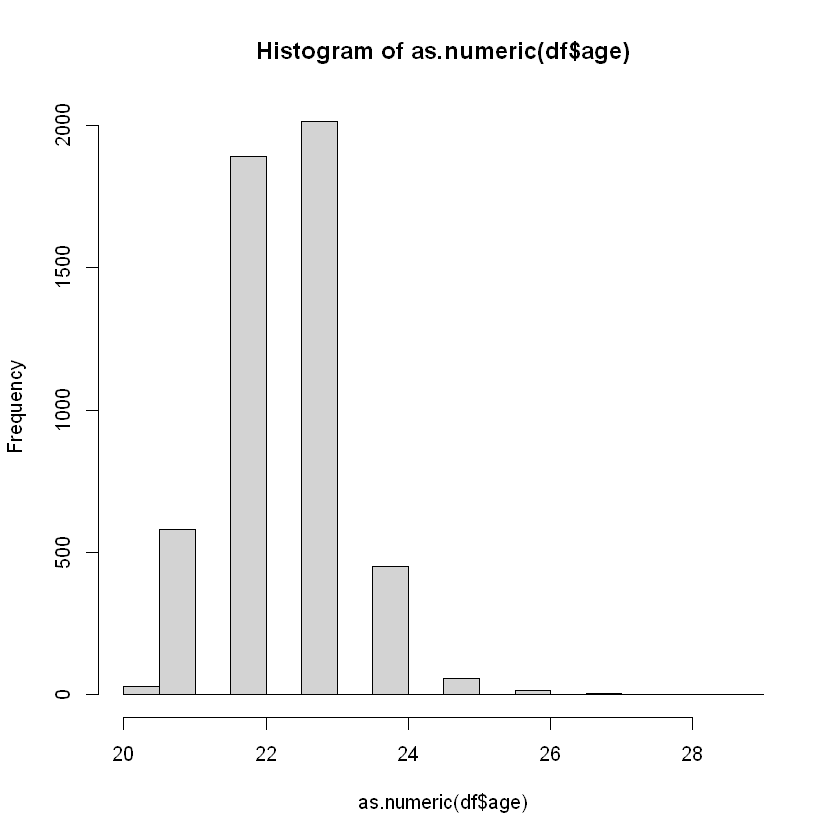

In [66]:
hist(as.numeric(df$age))

Since the high majority of the players are in the same age range, we can take the mean for the missing values

In [72]:
# pick == NAN
which(is.na(df$pick)) %>% head()

[1] 5351 5352 5353 5354 5355 5356

In [75]:
df[5351:6350, ] %>% select(player,url,year, pick, round) %>% sample_n(5)

player,url,year,pick,round
<chr>,<chr>,<int>,<chr>,<chr>
Corey Brown,https://www.sports-reference.com/cfb/players/corey-brown-1.html,2001,NA,NA
Antonio Malone,https://www.sports-reference.com/cfb/players/antonio-malone-1.html,2006,NA,NA
DeAngelo Lloyd,https://www.sports-reference.com/cfb/players/deangelo-lloyd-1.html,2001,NA,NA
Jesse Ainsworth,https://www.sports-reference.com/cfb/players/jesse-ainsworth-1.html,2007,NA,NA
Ben Dougherty,NA,2005,NA,NA


In [ ]:
# assign nan pick values to 257 and nan round number to 8
df$pick[is.na(combined$pick)] <- 257
df$pick[is.na(combined$round)] <- 8

After checking the draft picks of several college players with missing target variable manually, we found out that these players didn´t get picked in the season and decided to assign it to the value 257 (total number of games in NFL season +1) and round number to 8 (total round +1).  

In [77]:
head(college.stats)

url,section,stat,value,value.mean
<chr>,<chr>,<chr>,<dbl>,<dbl>
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,games,38,1.0000000
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rec.td,17,0.4473684
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rec.yards,1830,48.1578947
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,receptions,376,9.8947368
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rush.att,8,0.2105263
http://www.sports-reference.com/cfb/players/ahmaad-galloway-1.html,rushing,rush.td,0,0.0000000


In [124]:
# rename and drop columns to combine with combine and draft tables
stats.df <- college.stats %>% select(-value) %>% rename(value = value.mean, key = url)
tail(stats.df)

key,section,stat,value
<chr>,<chr>,<chr>,<dbl>
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,rec.td,0.05263158
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,rec.yards,12.57894737
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,receptions,1.00000000
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,scrim.plays,1.00000000
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,scrim.tds,0.05263158
https://www.sports-reference.com/cfb/players/zeron-flemister-1.html,receiving,scrim.yds,12.57894737


In [140]:
dim(stats.df)

[1] 32412     4

In [145]:
# convert the college stats  into wide format
data_wide <- spread(stats.df, stat, value)
head(data_wide,2)

key,section,ast.tackles,attempts,completions,fum.forced,fum.rec,fum.tds,fum.yds,games,...,pd,rec.td,rec.yards,receptions,rush.td,sacks,scrim.plays,scrim.tds,scrim.yds,tackles
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://www.sports-reference.com/cfb/players/aaron-hernandez-1.html,receiving,NA,NA,NA,NA,NA,NA,NA,1,...,NA,0.3,34.55,2.775,NA,NA,2.8,0.3,34.95,NA
http://www.sports-reference.com/cfb/players/aaron-kampman-1.html,defense,NA,NA,NA,NA,NA,NA,NA,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [154]:
#join dataframes 
df2<- full_join(df,data_wide, by="key")

ML Training
The purpose of this model is to forecast the players which will be picked in first round of NFL draft. Sean J. Taylor posted in his github repository a forecasting model based on the same data sources for 2000-2016 by using mice imputation for the combine scores and building a dense model. 
As described above, we used the same data sources to scrape data for the time interval till 2020. 
#Number of college stats available 
#Number of players in NFL combine and Draft 
#Players in total

In [152]:
#install.packages("tidymodels")
library(mlbench)
library(tidyverse)
library(workflows)
library(tune)
library(tidymodels)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()         masks stats::filter()
x readr::guess_encoding() masks rvest::guess_encoding()
x dplyr::lag()            masks stats::lag()
x purrr::pluck()          masks rvest::pluck()

-- Attaching packages -------------------------------------- tidymodels 0.1.1 --

v broom     0.7.0      v parsnip   0.1.3 
v dials     0.0.9      v recipes   0.1.13
v infer     0.5.3      v rsample   0.0.8 
v modeldata 0.0.2      v yardstick 0.0.7 

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filter()   masks stats::filter()
x recipes::fixed()  masks stringr::fixed()
x dplyr::lag()      masks stats::lag()
x purrr::pluck()    masks rvest::pluck()
x yardstick::spec() masks r

In [155]:
# Outcome variables
pick <- df2$pick
carav <- df2$carav
first.round <- as.numeric(df2$pick <= 32)

In [156]:
names(df2)

[1] "player"       "year"         "round"        "team"         "age"         
 [6] "college"      "url"          "pick"         "pos"          "carav"       
[11] "drav"         "key"          "weight"       "forty"        "vertical"    
[16] "broad"        "bench"        "threecone"    "shuttle"      "height"      
[21] "section"      "ast.tackles"  "attempts"     "completions"  "fum.forced"  
[26] "fum.rec"      "fum.tds"      "fum.yds"      "games"        "int"         
[31] "int.td"       "loss.tackles" "pass.tds"     "pass.yards"   "pd"          
[36] "rec.td"       "rec.yards"    "receptions"   "rush.td"      "sacks"       
[41] "scrim.plays"  "scrim.tds"    "scrim.yds"    "tackles"

In [167]:
df2 %>%
  select(-key, -player, -carav, -url, -round) %>%
  mutate(first.round = as.factor(first.round)) -> training.df

In [168]:
training_split = initial_split(training.df, prop = 3/4)

df_train = training(training_split)
df_test = testing(training_split)

df_cv = vfold_cv(df_train)

In [ ]:
is.na(training.df$pick)

In [169]:
recipe(first.round ~ .,
       data=df_train) %>%
  step_string2factor(all_nominal()) %>%
  step_knnimpute(all_predictors()) %>%
  step_dummy(all_nominal(), -all_outcomes()) -> df_recipe


rand_forest() %>%
  set_args(mtry = tune(),
           trees = 300) %>%
  set_engine('ranger', importance = 'impurity') %>%
  set_mode('classification') -> rf_model


rand_forest() %>%
  set_args(mtry = tune(),
           trees = 300) %>%
  set_engine('ranger', importance = 'impurity') %>%
  set_mode('classification') -> rf_model


rf_workflow = workflow() %>%
  add_recipe(df_recipe) %>%
  add_model(rf_model)

In [ ]:
#install.packages("ranger")
library(ranger)
rf_grid = expand.grid(mtry = c(10, 12, 15))

rf_workflow %>%
  tune_grid(resamples = df_cv,
            grid = rf_grid,
            metrics = metric_set(accuracy)) -> rf_tune_results

rf_tune_results %>%
  collect_metrics()

In [ ]:
rf_tune_results %>%
  select_best(metric = 'accuracy') -> param_final

rf_workflow %>%
  finalize_workflow(param_final) -> rf_workflow


rf_workflow %>%
  last_fit(training_split) -> rf_fit

rf_fit %>% collect_metrics()